### This colab notebook is for the deep learning project(Group 20).
### dataset: https://github.com/Hua-YS/AID-Multilabel-Dataset
### Author: Cheng Huang, Zhiwei Zeng, Haoyu Guo

In this project, we will use the AID-Multilabel-Dataset, a dataset for multi-label classification of remote sensing images to do the multi-label classification task. However, due to the label positive, negative imblance probelm, we will build three some models based on three different loss functions(Binary cross entropy, Focal Loss, Asymmetric Loss) to evaluate the performance.


## Install required packages

In [ ]:
!pip3 install wheels
!pip3 install pandas
!python3 -m pip install matplotlib
!pip3 install tqdm
!pip3 install scikit-learn
!pip3 install pandas

## Import required packages

In [27]:
import torchvision.models as models
from torch import nn
import torch
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import copy
# Imports for calculating metrics
from PIL import *
from sklearn.metrics import f1_score, recall_score, precision_score
import torch.nn.functional as F

## Change to GPU

In [28]:
# It's very important here because we use Mac M1 chip to train so we use 'mps' here
# If you use Nvidia, please use CUDA
device = torch.device('mps')

In [29]:
device

device(type='mps')

## Global Variables

In [30]:
# AID Dataser
## Training set path
training_path = '/Users/huangcheng/Documents/newAIDDataset/images/images_tr/'
## test set path
test_path = '/Users/huangcheng/Documents/newAIDDataset/images/images_test/'
## the number of classes
num_class = 17
## csv path
data_csv = '/Users/huangcheng/Documents/newAIDDataset/newlabelfinal.csv'

batch_size =32
num_epoch = 14

## Import CSV Files

In [31]:
cats = pd.read_csv(data_csv, header=None)
cats = list(cats[0])
cats = cats[1:]

In [32]:
data = pd.read_csv(data_csv)
data.head()

,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,airport_1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
1,airport_2,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0
2,airport_3,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
3,airport_4,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
4,airport_5,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0


## Create the model (VGG16 + ower own top layer)

In [56]:
def set_parameter_requires_grad(model):
    for name, param in model_ft.named_parameters():
        if "classifier.6.weight" in name or "classifier.6.bias" in name: #or "classifier.0.weight" in name or "classifier.0.bias" in name or "classifier.3.weight" in name or "classifier.3.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

In [57]:
## approach 1
# model_ft = models.vgg16(pretrained=True)
# set_parameter_requires_grad(model_ft, True)
# num_ftrs = model_ft.classifier[0].in_features  
# model_ft.classifier = nn.Linear(num_ftrs,num_class)
# model_ft.to(device)
# print(model_ft)

# # approach 2
# model_ft = models.vgg16(pretrained=True)
# set_parameter_requires_grad(model_ft, True)
# model_ft.classifier.add_module('add_linear', nn.Linear(1000, num_class))
# model_ft.to(device)
# print(model_ft)

# approach 3
model_ft = models.vgg16(pretrained=True)
set_parameter_requires_grad(model_ft)
model_ft.classifier[6] = nn.Linear(4096, num_class)
model_ft.to(device)
print(model_ft)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorchlearn/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pytorchlearn/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Image normalization layer

In [35]:
# Transformations on the data
# transformations = transforms.Compose([transforms.Resize((224, 224)),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                                      ])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5), 
        transforms.ColorJitter(brightness=0.1),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## DataLoader

In [36]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transformations, train):
        """
        Args:
            csv_path (string): path to csv file
            transform: pytorch transforms for transforms and tensor conversion
            train: flag to determine if train or val set
        """
        # Transforms
        self.transforms = transformations
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        self.train = train
        # First column contains the image paths
        if train:
            self.image_arr = (self.data_info.iloc[0:2400, 0])
        else:
            self.image_arr = (self.data_info.iloc[2400:2700, 0])
  
        self.image_arr = np.asarray(self.image_arr)
        # Second column is the labels
        if train:
            self.label_arr = np.asarray(self.data_info.iloc[0:2400, 1:])
        else:
            self.label_arr = np.asarray(self.data_info.iloc[2400:2700, 1:])

        # Third column is for an operation indicator
        #self.operation_arr = np.asarray(self.data_info.iloc[:, 2])
        # Calculate len
        self.data_len = len(self.label_arr)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = training_path+self.image_arr[index] + ".jpg"
        # Open image
        img_as_img = Image.open(single_image_name).convert('RGB')

        if self.transforms is not None and self.train == True:
            img_as_tensor = self.transforms['train'](img_as_img)
        if self.transforms is not None and self.train == False:
            img_as_tensor = self.transforms['val'](img_as_img)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [37]:
# Define a dictionary of dataset
# one for train and one for validation
image_datasets = {'train': CustomDatasetFromCSV(data_csv, data_transforms, True), 
                 'val': CustomDatasetFromCSV(data_csv, data_transforms, False)}


In [38]:
# Define data loader
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=0) for x in ['train', 'val']}

## Map image name and label

In [39]:
# all_data_csv = '/Users/huangcheng/Documents/newAIDDataset/multilabel.csv'
# all_data_csv = '/Users/huangcheng/Downloads/hbku/labels/labels_train.csv'
labels = pd.read_csv(data_csv)
name_label_dic = {}
labels.iloc[1]
for i in tqdm(range(labels.shape[0])):
  label = []
  for j in range(1, num_class+1):
    label.append(labels.iloc[i][j])
  name_label_dic[labels.iloc[i][0]] = label


100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1847.06it/s]


## Calculate Accuracy Function

In [40]:
# Function for calculating accuracy of the model
def calc_accuracy(preds, labels):
    return (np.sum(np.around(preds.cpu().detach().numpy()) == labels.cpu().detach().numpy()))

## Plot Loss Function

In [41]:
def draw_plot(train_loss, val_loss, num_epoch):
    epoch_range = range(1, num_epoch+1)
    plt.plot(epoch_range, train_loss)
    plt.plot(epoch_range, val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()


## Evaluate the model(Precision, Recall, F1 Score)

In [42]:
def experiment_evaluate(model_ft):
    y_true = []
    y_predict = []
    
    for img_name in tqdm(os.listdir(test_path)):
        if img_name.endswith(".jpg") == False:
          continue;
        img_path = test_path + img_name
        sample_img = Image.open(img_path).convert('RGB')
        img_tensor = data_transforms['val'](sample_img)
        img_tensor = img_tensor.reshape(1, 3, 224, 224)
        true_label = name_label_dic[img_name[:-4]]
        y_true.append(true_label)
        model_ft.eval()
        with torch.no_grad():
            img_tensor_tensor = img_tensor.to(device)
            outputs = model_ft(img_tensor_tensor)
            outputs = torch.sigmoid(outputs)
            preds_label = np.around(outputs.cpu().detach().numpy())[0].tolist()
            y_predict.append(preds_label)
    
    precision = precision_score(y_true, y_predict, average=None, zero_division=1)
    recall = recall_score(y_true, y_predict, average=None, zero_division=1)
    f1 = f1_score(y_true, y_predict, average=None, zero_division=1)
    
    precision_micro = precision_score(y_true, y_predict, zero_division=1, average = 'micro')
    recall_micro = recall_score(y_true, y_predict, zero_division=1, average = 'micro')    
    f1_micro = f1_score(y_true, y_predict, zero_division=1, average = 'micro')
    
    return precision, recall, f1, precision_micro, recall_micro, f1_micro


## Train Model Function

In [54]:
def train_model(model, dataloaders, criterion, optimizer, num_epoch, loss_name):
  '''
      model: Model need to train
      dataloaders: dataloaders to get data
      criterion: Loss function(we will use three differernt loss function, Binary Cross Entropy, Focal Loss and ASL)
      optimizer: we use Adam here
      num_epoch: the default num_epoch is 25
  '''
  since = time.time()
  val_acc_history = []
  loss_train = []
  loss_val = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epoch):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.float()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        # In validation phase, we will not calculate the gradiant, so set it to false can reduce memory consumption
        with torch.set_grad_enabled(phase == 'train'): 
          # Get model outputs and calculate loss
          outputs = model(inputs)
          if loss_name == "bce":
            outputs = torch.sigmoid(outputs)
          loss = criterion(outputs, labels)
          preds = outputs
          
          if phase == 'train':
            loss.backward() # back propagation to calculate the grad
            optimizer.step() # optimize the weight
          
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += calc_accuracy(preds, labels.data)
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)      
      if phase == 'train':
        loss_train.append(epoch_loss)
      if phase == 'val':
        loss_val.append(epoch_loss)
      print('epoch:{} {} Loss: {:.4f}'.format(epoch, phase, epoch_loss))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
  model.load_state_dict(best_model_wts)
  return model, loss_train, loss_val

## Here we train the model with Adam and Binary Cross Entropy

In [45]:
# The first parameter is the model's parameter that need to train
# The second parameter is the learning rate
bce_optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
# Binary Cross Entropy loss function
bce_criterion = torch.nn.BCELoss().to(device)
bce_model, bce_train_loss, bce_val_loss = train_model(model_ft, dataloaders_dict, bce_criterion, bce_optimizer, num_epoch=num_epoch, loss_name = "bce")


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:0 train Loss: 0.2690 Acc: 15.1475


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


epoch:0 val Loss: 0.2136 Acc: 15.6100


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:1 train Loss: 0.2036 Acc: 15.6217


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


epoch:1 val Loss: 0.1957 Acc: 15.7433


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:2 train Loss: 0.1916 Acc: 15.6813


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:2 val Loss: 0.1909 Acc: 15.7733


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:3 train Loss: 0.1840 Acc: 15.7442


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:3 val Loss: 0.1857 Acc: 15.8367


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:4 train Loss: 0.1763 Acc: 15.7967


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:4 val Loss: 0.1850 Acc: 15.8600


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:5 train Loss: 0.1768 Acc: 15.7975


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:5 val Loss: 0.1837 Acc: 15.8367


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:6 train Loss: 0.1715 Acc: 15.8342


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:6 val Loss: 0.1841 Acc: 15.8500


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.16it/s]


epoch:7 train Loss: 0.1694 Acc: 15.8142


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:7 val Loss: 0.1862 Acc: 15.8533


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.17it/s]


epoch:8 train Loss: 0.1679 Acc: 15.8446


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:8 val Loss: 0.1827 Acc: 15.8700


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:9 train Loss: 0.1656 Acc: 15.8650


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:9 val Loss: 0.1838 Acc: 15.8833


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:10 train Loss: 0.1656 Acc: 15.8683


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:10 val Loss: 0.1836 Acc: 15.9033


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:11 train Loss: 0.1664 Acc: 15.8488


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:11 val Loss: 0.1774 Acc: 15.8867


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:12 train Loss: 0.1612 Acc: 15.8858


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:12 val Loss: 0.1804 Acc: 15.8967


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:13 train Loss: 0.1621 Acc: 15.8917


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]

epoch:13 val Loss: 0.1817 Acc: 15.9200


## Plot the Loss with Binary Cross Entropy

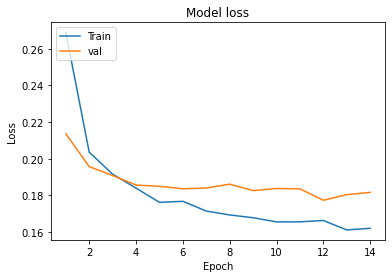

In [46]:
draw_plot(bce_train_loss, bce_val_loss, num_epoch)

In [119]:
torch.save(bce_model,"/Users/huangcheng/Downloads/hbku/aid_lr0001_bs32/bce.pth")

## Evluate the Model with Binary Cross Entropy

In [47]:
precision, recall, f1, precision_micro, recall_micro, f1_micro  = experiment_evaluate(bce_model)
print(precision)
print(recall)
print(f1)

print("precision_micro = ", precision_micro)
print("recall_micro = ", recall_micro)
print("f1_micro = ", f1_micro)

100%|█████████████████████████████████████████| 301/301 [00:13<00:00, 22.31it/s]

[1.         0.7414966  0.95348837 0.90454545 1.         0.6
 0.8        0.75       0.92741935 1.         0.95744681 1.
 0.8        0.69230769 0.66666667 0.90625    0.6440678 ]
[0.4        0.76223776 0.96698113 0.96135266 0.         0.32432432
 0.46153846 0.57142857 0.9787234  0.         0.97826087 0.76
 0.54545455 0.39130435 0.8        0.95473251 0.41304348]
[0.57142857 0.75172414 0.96018735 0.93208431 0.         0.42105263
 0.58536585 0.64864865 0.95238095 0.         0.96774194 0.86363636
 0.64864865 0.5        0.72727273 0.92985972 0.50331126]
precision_micro =  0.8875502008032129
recall_micro =  0.8527331189710611
f1_micro =  0.8697933748770088


## Focal Loss Function Class

In [55]:
class FocalLoss(nn.Module):

    def __init__(self, alpha=.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        return loss.mean()

## Here we train the model with Adam and Focal Loss

In [58]:
# The first parameter is the model's parameter that need to train
# The second parameter is the learning rate
focal_optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
# Binary Cross Entropy loss function
focal_criterion = FocalLoss(alpha=.25, gamma=2).to(device)
focal_model, focal_train_loss, focal_val_loss = train_model(model_ft, dataloaders_dict, focal_criterion, focal_optimizer, num_epoch=25,loss_name = "focal")

100%|███████████████████████████████████████████| 75/75 [01:05<00:00,  1.15it/s]


epoch:0 train Loss: 0.0459


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:0 val Loss: 0.0327


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:1 train Loss: 0.0310


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:1 val Loss: 0.0282


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.17it/s]


epoch:2 train Loss: 0.0281


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:2 val Loss: 0.0258


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:3 train Loss: 0.0263


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:3 val Loss: 0.0246


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.16it/s]


epoch:4 train Loss: 0.0249


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:4 val Loss: 0.0239


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:5 train Loss: 0.0239


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:5 val Loss: 0.0234


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:6 train Loss: 0.0234


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:6 val Loss: 0.0226


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:7 train Loss: 0.0230


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:7 val Loss: 0.0223


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:8 train Loss: 0.0224


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:8 val Loss: 0.0222


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:9 train Loss: 0.0216


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:9 val Loss: 0.0216


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:10 train Loss: 0.0214


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:10 val Loss: 0.0214


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:11 train Loss: 0.0212


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:11 val Loss: 0.0210


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:12 train Loss: 0.0210


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:12 val Loss: 0.0209


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:13 train Loss: 0.0206


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:13 val Loss: 0.0206


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.17it/s]


epoch:14 train Loss: 0.0201


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:14 val Loss: 0.0204


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:15 train Loss: 0.0202


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:15 val Loss: 0.0202


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:16 train Loss: 0.0195


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.25it/s]


epoch:16 val Loss: 0.0201


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.17it/s]


epoch:17 train Loss: 0.0196


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:17 val Loss: 0.0201


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:18 train Loss: 0.0196


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:18 val Loss: 0.0200


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:19 train Loss: 0.0192


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:19 val Loss: 0.0199


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:20 train Loss: 0.0193


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:20 val Loss: 0.0197


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.17it/s]


epoch:21 train Loss: 0.0188


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:21 val Loss: 0.0197


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:22 train Loss: 0.0188


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:22 val Loss: 0.0196


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:23 train Loss: 0.0187


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:23 val Loss: 0.0197


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.17it/s]


epoch:24 train Loss: 0.0186


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]

epoch:24 val Loss: 0.0197


## Plot the Loss with Focal Loss

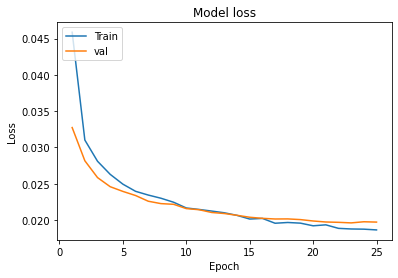

In [59]:
draw_plot(focal_train_loss, focal_val_loss, 25)

## Evluate the Model with Focal Loss

In [60]:
precision, recall, f1, precision_micro, recall_micro, f1_micro = experiment_evaluate(focal_model)
print(precision)
print(recall)
print(f1)

print("precision_micro = ", precision_micro)
print("recall_micro = ", recall_micro)
print("f1_micro = ", f1_micro)

100%|█████████████████████████████████████████| 301/301 [00:13<00:00, 22.17it/s]


[1.         0.74418605 0.93150685 0.90654206 1.         1.
 1.         1.         0.86666667 1.         0.89837398 1.
 1.         1.         1.         0.88549618 1.        ]
[0.         0.22377622 0.96226415 0.93719807 0.         0.
 0.         0.         0.94042553 0.         0.96086957 0.
 0.         0.         0.         0.95473251 0.        ]
[0.         0.34408602 0.94663573 0.9216152  0.         0.
 0.         0.         0.90204082 0.         0.92857143 0.
 0.         0.         0.         0.91881188 0.        ]
precision_micro =  0.8910411622276029
recall_micro =  0.7099678456591639
f1_micro =  0.7902648532569793


## ASL Loss Function Class

In [61]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


## Here we train the model with Adam and ASL

In [145]:
# The first parameter is the model's parameter that need to train
# The second parameter is the learning rate
asl_optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
# Binary Cross Entropy loss function
asl_criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0).to(device)
asl_model, asl_train_loss, asl_val_loss = train_model(model_ft, dataloaders_dict, asl_criterion, asl_optimizer, num_epoch=num_epoch, loss_name='asl')

100%|█████████████████████████████████████████| 300/300 [01:05<00:00,  4.60it/s]


epoch:0 train Loss: 8.3593 Acc: 15.9817


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


epoch:0 val Loss: 13.4085 Acc: 15.6733


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.52it/s]


epoch:1 train Loss: 8.4509 Acc: 15.9833


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:1 val Loss: 12.3881 Acc: 15.8267


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:2 train Loss: 9.1749 Acc: 15.9392


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:2 val Loss: 12.5390 Acc: 15.7967


100%|█████████████████████████████████████████| 300/300 [01:05<00:00,  4.55it/s]


epoch:3 train Loss: 9.2882 Acc: 15.9404


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


epoch:3 val Loss: 13.3908 Acc: 15.7400


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:4 train Loss: 9.5494 Acc: 15.9167


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


epoch:4 val Loss: 12.5986 Acc: 15.8300


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.52it/s]


epoch:5 train Loss: 9.8147 Acc: 15.9337


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


epoch:5 val Loss: 13.8882 Acc: 15.7333


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.53it/s]


epoch:6 train Loss: 9.3915 Acc: 15.9563


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:6 val Loss: 14.0136 Acc: 15.7933


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.51it/s]


epoch:7 train Loss: 9.8295 Acc: 15.9413


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


epoch:7 val Loss: 13.8897 Acc: 15.8267


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:8 train Loss: 9.2443 Acc: 15.9621


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:8 val Loss: 13.9992 Acc: 15.7667


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:9 train Loss: 9.7586 Acc: 15.9308


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


epoch:9 val Loss: 13.5180 Acc: 15.8267


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:10 train Loss: 9.9880 Acc: 15.9371


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


epoch:10 val Loss: 14.4672 Acc: 15.8133


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.53it/s]


epoch:11 train Loss: 10.3039 Acc: 15.9046


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:11 val Loss: 13.4157 Acc: 15.8100


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.49it/s]


epoch:12 train Loss: 10.0242 Acc: 15.9258


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


epoch:12 val Loss: 14.9180 Acc: 15.8567


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.51it/s]


epoch:13 train Loss: 9.8978 Acc: 15.9746


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.50it/s]

epoch:13 val Loss: 14.4166 Acc: 15.8267


## Save Model

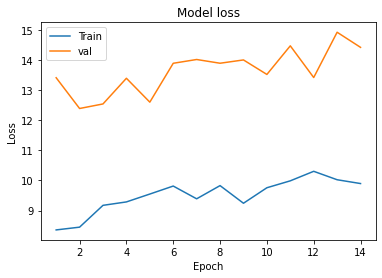

[8.359346409638723, 8.45092772046725, 9.17492939511935, 9.288181026776632, 9.54939340988795, 9.814677669604619, 9.39150926510493, 9.829498618443807, 9.244297788143157, 9.758563186526299, 9.987984421253204, 10.303865460554759, 10.02416127840678, 9.897778488000235]
[13.408462320963542, 12.388080501556397, 12.539042002360025, 13.390822054545085, 12.598635133107503, 13.88820925394694, 14.013565969467162, 13.88972250620524, 13.999203898111979, 13.518046925862631, 14.467167930603027, 13.415689633687338, 14.918022842407227, 14.416557280222575]


In [146]:
draw_plot(asl_train_loss, asl_val_loss, num_epoch)

print(asl_train_loss)
print(asl_val_loss)

## Evaluate the Model with ASL

In [147]:
precision, recall, f1, precision_micro, recall_micro, f1_micro = experiment_evaluate(asl_model)
print(precision)
print(recall)
print(f1)

print("precision_micro = ", precision_micro)
print("recall_micro = ", recall_micro)
print("f1_micro = ", f1_micro)

100%|█████████████████████████████████████████| 301/301 [00:13<00:00, 22.34it/s]

[1.         0.65591398 0.93150685 0.935      0.         0.40540541
 0.8125     0.8125     0.90551181 1.         0.94560669 1.
 0.86666667 0.5625     0.63636364 0.90769231 0.68253968]
[0.4        0.85314685 0.96226415 0.90338164 0.         0.40540541
 0.5        0.61904762 0.9787234  0.         0.9826087  0.76
 0.59090909 0.39130435 0.7        0.97119342 0.4673913 ]
[0.57142857 0.74164134 0.94663573 0.91891892 0.         0.40540541
 0.61904762 0.7027027  0.9406953  0.         0.96375267 0.86363636
 0.7027027  0.46153846 0.66666667 0.93836978 0.55483871]
avg precision =  0.7682180607095107
avg recall =  0.6167868193931593
avg f1 =  0.6469400548853038
